In [1]:
import pandas as pd


comp_data = 'compiled_upright_torque_july11.dat'

df = pd.read_csv(comp_data, sep=',')
df

,rod_id,trial,measurement_index,point_index,value
0,Rod3,N1,0,0,-0.00129
1,Rod3,N1,0,1,-0.02068
2,Rod3,N1,0,2,-0.02184
3,Rod3,N1,0,3,-0.02496
4,Rod3,N1,0,4,-0.02710
...,...,...,...,...,...
5695,Rod3,N12,99,3,-0.02216
5696,Rod3,N12,99,4,-0.02364
5697,Rod3,N12,99,5,-0.02364
5698,Rod3,N12,99,6,-0.02726


In [2]:
rod_chars = 'dataTorque/rod-lenght.txt'
dfC = pd.read_csv(rod_chars)
# Filter out broken rods (optional)
dfC = dfC[dfC['Rod'].str.contains("Rod") & ~dfC['Rod'].str.contains("not working|broken", case=False)].copy()

# Standardize rod_id
dfC['rod_id'] = dfC['Rod'].str.extract(r'(Rod\d+)')
# First merge main df with rod characteristics
df_merged = pd.merge(df, dfC.drop(columns=['Rod']), on='rod_id', how='left')
df_merged


,rod_id,trial,measurement_index,point_index,value,material,lenght,diammeter
0,Rod3,N1,0,0,-0.00129,al,182mm,1.6mm
1,Rod3,N1,0,1,-0.02068,al,182mm,1.6mm
2,Rod3,N1,0,2,-0.02184,al,182mm,1.6mm
3,Rod3,N1,0,3,-0.02496,al,182mm,1.6mm
4,Rod3,N1,0,4,-0.02710,al,182mm,1.6mm
...,...,...,...,...,...,...,...,...
5695,Rod3,N12,99,3,-0.02216,al,182mm,1.6mm
5696,Rod3,N12,99,4,-0.02364,al,182mm,1.6mm
5697,Rod3,N12,99,5,-0.02364,al,182mm,1.6mm
5698,Rod3,N12,99,6,-0.02726,al,182mm,1.6mm


In [3]:
# Length of the rod (inches)
rod_length_in = 3.84375

# Heights measured *from tip of rod to ruler bottom* (inches)
height_in_dict = {
    "N1": 0.94,  "N12": 0.94,   # Height‑setting 1, runs A/B
    "N2": 1.90, "N22": 1.90,    # Height‑setting 2, runs A/B
    "N3": 2.86, "N32": 2.86,    # Height‑setting 3, runs A/B
    "N4": 3.82, "N42": 3.82,    # Height‑setting 4, runs A/B
}

# Convert “tip‑to‑bottom” measurements into the height of the **top of the rod**
# relative to the ruler’s bottom (i.e., remaining rod length above the ruler)
clearance_in_dict = {label: rod_length_in - h for label, h in height_in_dict.items()}

# Convert to millimetres (1 inch = 25.4 mm)
height_mm_dict = {k: v * 25.4 for k, v in clearance_in_dict.items()}

# Turn into a DataFrame so we can merge
height_df = (
    pd.Series(height_mm_dict, name='height_mm')
      .rename_axis('trial')
      .reset_index()
)

df_merged = (
    df_merged  # <- your original dataframe variable
    .merge(height_df, on='trial', how='left')
)
df_merged

,rod_id,trial,measurement_index,point_index,value,material,lenght,diammeter,height_mm
0,Rod3,N1,0,0,-0.00129,al,182mm,1.6mm,73.75525
1,Rod3,N1,0,1,-0.02068,al,182mm,1.6mm,73.75525
2,Rod3,N1,0,2,-0.02184,al,182mm,1.6mm,73.75525
3,Rod3,N1,0,3,-0.02496,al,182mm,1.6mm,73.75525
4,Rod3,N1,0,4,-0.02710,al,182mm,1.6mm,73.75525
...,...,...,...,...,...,...,...,...,...
5695,Rod3,N12,99,3,-0.02216,al,182mm,1.6mm,73.75525
5696,Rod3,N12,99,4,-0.02364,al,182mm,1.6mm,73.75525
5697,Rod3,N12,99,5,-0.02364,al,182mm,1.6mm,73.75525
5698,Rod3,N12,99,6,-0.02726,al,182mm,1.6mm,73.75525


In [4]:
position_map = { #mm
    0: 0,
    1: 100,
    2: 90,
    3: 80,
    4: 70,
    5: 60,
    6: 50,
    7: 40,
    # Add more if needed
}

summary_df = (
    df_merged
    .groupby(['rod_id','trial', 'point_index'])
    .agg(
       mean_voltage=('value', 'mean'),
       std_voltage=('value', 'std')
    )
    .reset_index()
)
summary_df['position'] = summary_df['point_index'].map(position_map)
  # X axis

# Merge height_mm from df_merged
height_lookup = df_merged[['trial', 'height_mm']].drop_duplicates()
summary_df = summary_df.merge(height_lookup, on='trial', how='left')

# Optionally reorder columns
summary_df = summary_df[['rod_id','trial', 'point_index', 'position', 'height_mm','mean_voltage', 'std_voltage']]

summary_df

,rod_id,trial,point_index,position,height_mm,mean_voltage,std_voltage
0,Rod3,N1,0,0,73.75525,-0.001195,0.000138
1,Rod3,N1,1,100,73.75525,-0.020363,0.000127
2,Rod3,N1,2,90,73.75525,-0.021893,0.000121
3,Rod3,N1,3,80,73.75525,-0.024997,0.000147
4,Rod3,N1,4,70,73.75525,-0.027393,0.000128
5,Rod3,N1,5,60,73.75525,-0.028607,0.000147
6,Rod3,N1,6,50,73.75525,-0.034607,0.000122
7,Rod3,N12,0,0,73.75525,0.000316,0.000139
8,Rod3,N12,1,100,73.75525,-0.018481,0.000133
9,Rod3,N12,2,90,73.75525,-0.019840,0.000157


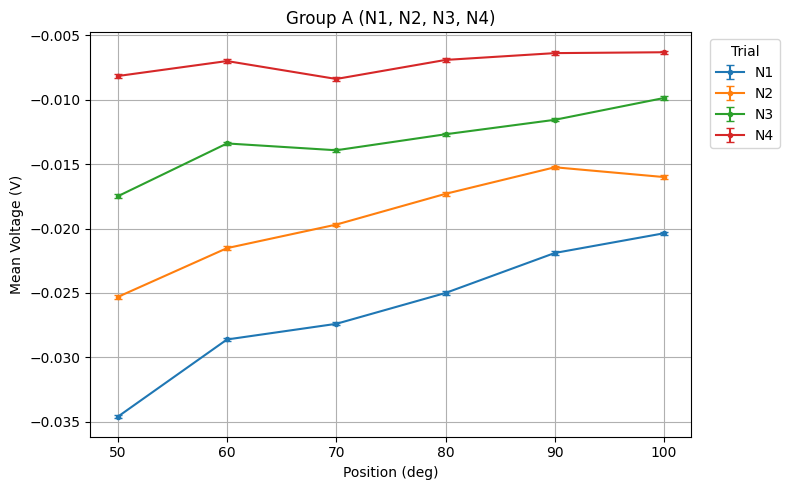

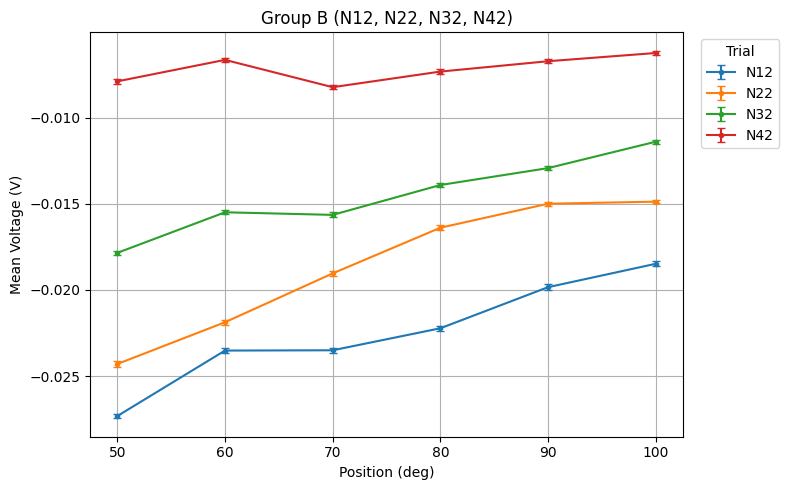

In [5]:
import matplotlib.pyplot as plt

# 1) keep only point_index 1–6
clean_df = summary_df[(summary_df['point_index'] >= 1) &
                      (summary_df['point_index'] <= 6)].copy()

# 2) explicit group membership
groupA_trials = ['N1', 'N2', 'N3', 'N4']
groupB_trials = ['N12', 'N22', 'N32', 'N42']

groupA = clean_df[clean_df['trial'].isin(groupA_trials)]
groupB = clean_df[clean_df['trial'].isin(groupB_trials)]

# 3) plotting function with error bars
def plot_group(df, title):
    plt.figure(figsize=(8,5))
    for trial, g in df.groupby('trial'):
        g_sorted = g.sort_values('position')
        plt.errorbar(
            g_sorted['position'],
            g_sorted['mean_voltage'],
            yerr=g_sorted['std_voltage'],
            marker='.',
            capsize=3,
            label=trial
        )
    plt.xlabel("Position (deg)")
    plt.ylabel("Mean Voltage (V)")
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Trial", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 4) generate plots
plot_group(groupA, "Group A (N1, N2, N3, N4)")
plot_group(groupB, "Group B (N12, N22, N32, N42)")


N1 fit: A = 1.37766 ± 0.01501, B = -0.00690 ± 0.00022


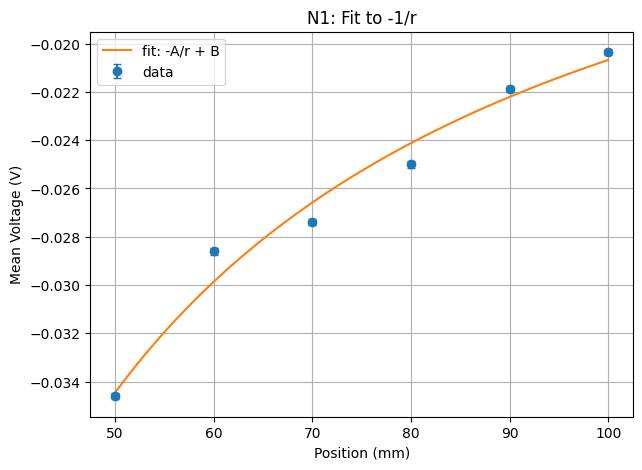

N12 fit: A = 0.79539 ± 0.01610, B = -0.01122 ± 0.00024


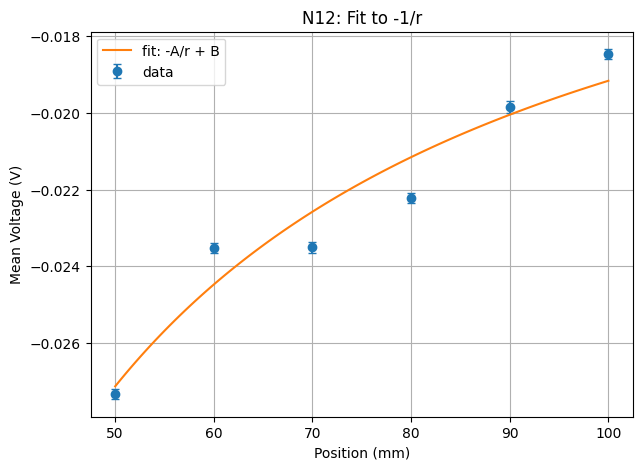

In [6]:
import numpy as np
from scipy.optimize import curve_fit

# pick trials N1 and N12
for trial in ['N1', 'N12']:
    g = clean_df[clean_df['trial'] == trial].sort_values('position')
    r = g['position'].values
    V = g['mean_voltage'].values
    Verr = g['std_voltage'].values

    # define -1/r model with offset
    def inv_r_model(r, A, B):
        return -A/r + B

    # fit using curve_fit with weights
    popt, pcov = curve_fit(inv_r_model, r, V, sigma=Verr, absolute_sigma=True)
    A, B = popt
    perr = np.sqrt(np.diag(pcov))

    print(f"{trial} fit: A = {A:.5f} ± {perr[0]:.5f}, B = {B:.5f} ± {perr[1]:.5f}")

    # plot data + fit
    r_fit = np.linspace(min(r), max(r), 100)
    V_fit = inv_r_model(r_fit, *popt)

    plt.figure(figsize=(7,5))
    plt.errorbar(r, V, yerr=Verr, fmt='o', capsize=3, label='data')
    plt.plot(r_fit, V_fit, '-', label=f'fit: -A/r + B')
    plt.xlabel("Position (mm)")
    plt.ylabel("Mean Voltage (V)")
    plt.title(f"{trial}: Fit to -1/r")
    plt.grid(True)
    plt.legend()
    plt.show()


N1 fit results: K = 0.62446, n = -0.742
Chi2 = 155.145, dof = 4, reduced Chi2 = 38.786
N1 power-law fit: K = 0.62446 ± 0.02117, n = -0.742 ± 0.008


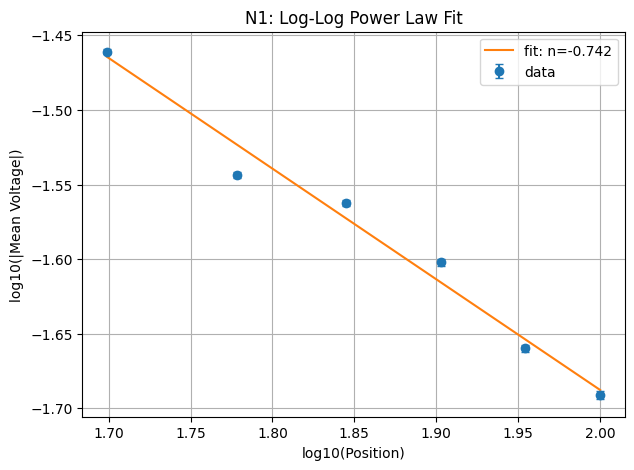

N1 fit results: K = 0.19436, n = -0.505
Chi2 = 179.200, dof = 4, reduced Chi2 = 44.800
N12 power-law fit: K = 0.19436 ± 0.00841, n = -0.505 ± 0.010


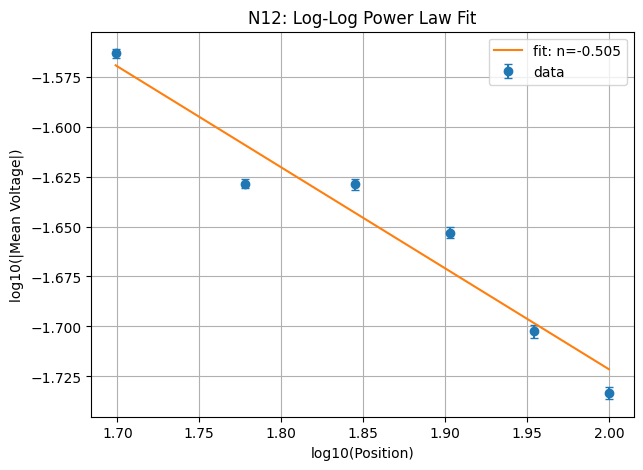

In [7]:
# function for log-log power-law fit
def power_law(r, K, n):
    return K * r**n

for trial in ['N1', 'N12']:
    g = clean_df[clean_df['trial'] == trial].sort_values('position')
    r = g['position'].values
    V = np.abs(g['mean_voltage'].values)  # use absolute value for log
    Verr = g['std_voltage'].values

    # fit in linear space, not log space (better weighting with sigma)
    popt, pcov = curve_fit(power_law, r, V, sigma=Verr, absolute_sigma=True)
    K, n = popt
    perr = np.sqrt(np.diag(pcov))

    # compute chi-squared
    V_model = power_law(r, *popt)
    chi2 = np.sum(((V - V_model)/Verr)**2)
    dof = len(V) - len(popt)  # 6 points - 2 params = 4
    chi2_red = chi2 / dof
    
    print(f"N1 fit results: K = {K:.5f}, n = {n:.3f}")
    print(f"Chi2 = {chi2:.3f}, dof = {dof}, reduced Chi2 = {chi2_red:.3f}")


    print(f"{trial} power-law fit: K = {K:.5f} ± {perr[0]:.5f}, n = {n:.3f} ± {perr[1]:.3f}")

    # plot log-log
    r_fit = np.linspace(min(r), max(r), 100)
    V_fit = power_law(r_fit, *popt)

    plt.figure(figsize=(7,5))
    plt.errorbar(np.log10(r), np.log10(V), yerr=Verr/V/np.log(10), fmt='o', capsize=3, label='data')
    plt.plot(np.log10(r_fit), np.log10(V_fit), '-', label=f'fit: n={n:.3f}')
    plt.xlabel("log10(Position)")
    plt.ylabel("log10(|Mean Voltage|)")
    plt.title(f"{trial}: Log-Log Power Law Fit")
    plt.grid(True)
    plt.legend()
    plt.show()


In [8]:
# power-law model
def power_law(r, K, n):
    return K * r**n

results = []

# list all trials
all_trials = ['N1', 'N2', 'N3', 'N4', 'N12', 'N22', 'N32', 'N42']

for trial in all_trials:
    g = clean_df[clean_df['trial'] == trial].sort_values('position')
    r = g['position'].values
    V = np.abs(g['mean_voltage'].values)  # use absolute for log-log
    Verr = g['std_voltage'].values

    # fit power law
    popt, pcov = curve_fit(power_law, r, V, sigma=Verr, absolute_sigma=True)
    K, n = popt
    perr = np.sqrt(np.diag(pcov))

    # chi-squared
    V_model = power_law(r, *popt)
    chi2 = np.sum(((V - V_model)/Verr)**2)
    dof = len(V) - len(popt)
    chi2_red = chi2 / dof

    results.append({
        'trial': trial,
        'K': K,
        'K_err': perr[0],
        'n': n,
        'n_err': perr[1],
        'chi2': chi2,
        'dof': dof,
        'chi2_red': chi2_red
    })

# make DataFrame
fit_table = pd.DataFrame(results)
fit_table


,trial,K,K_err,n,n_err,chi2,dof,chi2_red
0,N1,0.624457,0.021167,-0.741578,0.008052,155.145379,4,38.786345
1,N2,0.483446,0.025182,-0.756374,0.012369,116.217698,4,29.054425
2,N3,0.244787,0.017958,-0.684694,0.017343,213.995731,4,53.498933
3,N4,0.031877,0.004005,-0.348149,0.029473,102.172605,4,25.543151
4,N12,0.194361,0.008410,-0.505002,0.010247,179.200009,4,44.800002
5,N22,0.494620,0.024942,-0.768195,0.011850,82.136163,4,20.534041
6,N32,0.165506,0.009678,-0.569799,0.013889,97.206966,4,24.301742
7,N42,0.018869,0.002540,-0.226103,0.031475,128.750521,4,32.187630


## Heights

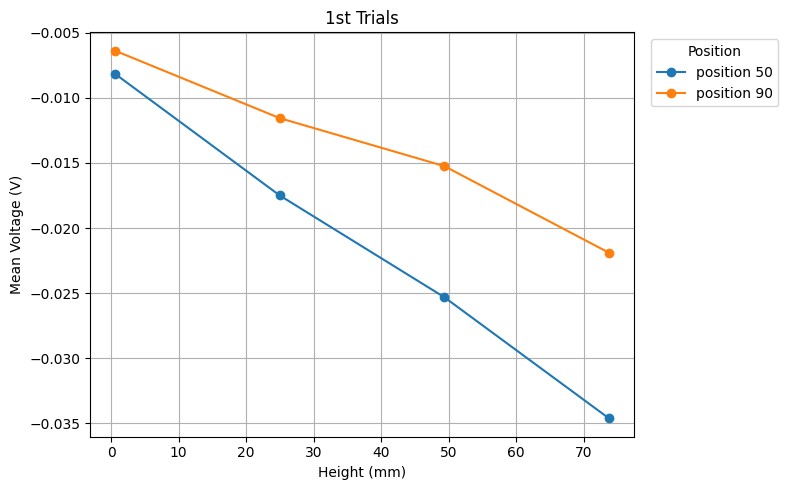

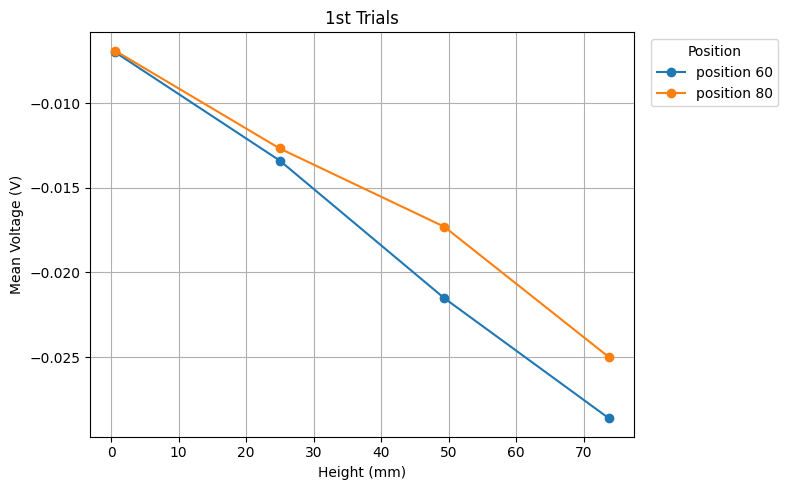

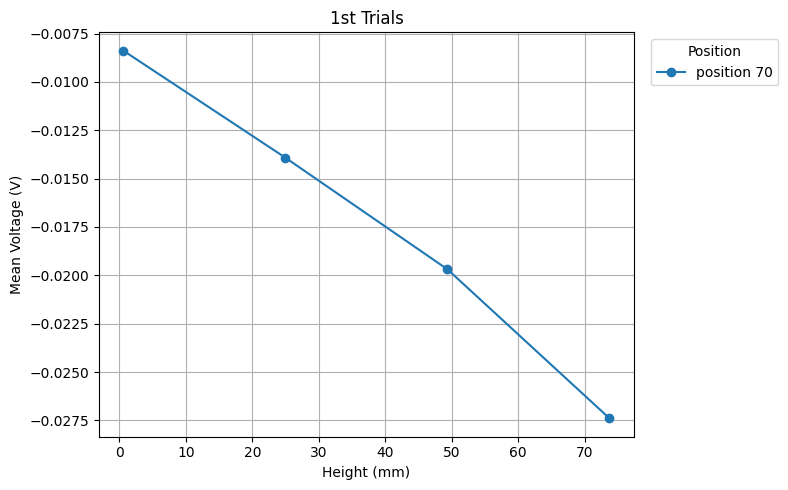

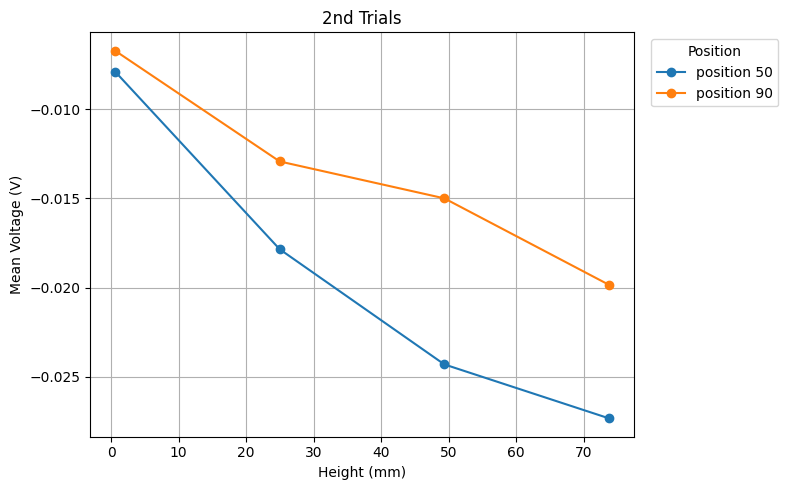

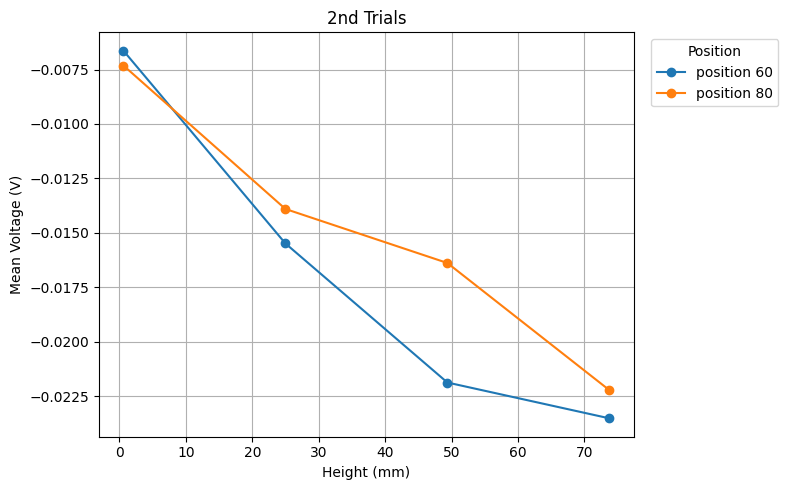

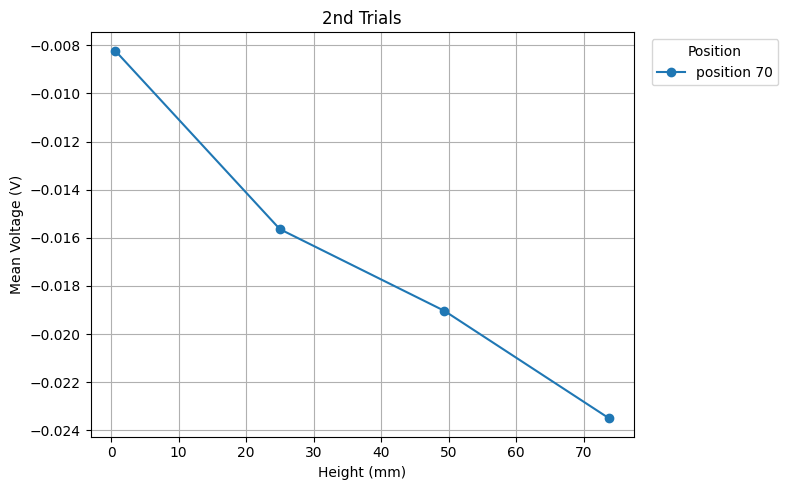

In [9]:
# define point_index groups
point_groups = {
    '6and2': [6, 2],
    '5and3': [5, 3],
    '4': [4]
}

def regroup_by_point_index(df):
    grouped = {}
    for name, indices in point_groups.items():
        grouped[name] = df[df['point_index'].isin(indices)].copy()
    return grouped

# apply to groupA and groupB
groupA_point_groups = regroup_by_point_index(groupA)
groupB_point_groups = regroup_by_point_index(groupB)

def plot_voltage_vs_height(point_groups, group_name):
    for pg_name, df in point_groups.items():
        plt.figure(figsize=(8,5))
        for pos in sorted(df['position'].unique()):
            g_pos = df[df['position'] == pos]
            plt.plot(
                g_pos['height_mm'],
                g_pos['mean_voltage'],
                marker='o',
                linestyle='-',
                label=f"position {pos}"
            )
        plt.xlabel("Height (mm)")
        plt.ylabel("Mean Voltage (V)")
        plt.title(f"{group_name}")
        plt.grid(True)
        plt.legend(title="Position", bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# plot for Group A
plot_voltage_vs_height(groupA_point_groups, "1st Trials")

# plot for Group B
plot_voltage_vs_height(groupB_point_groups, "2nd Trials")


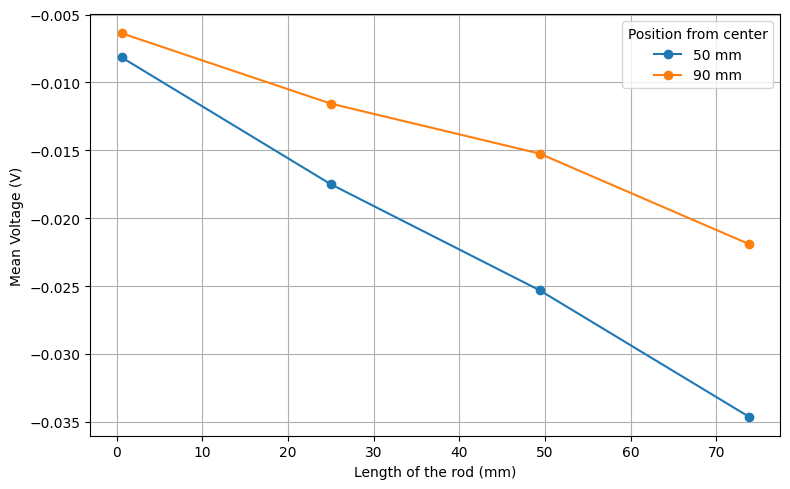

In [10]:
# filter data
df = groupA[groupA['position'].isin([50, 90])].copy()

# create figure
plt.figure(figsize=(8,5))



# plot each position (only 50 and 90 exist here)
for pos in sorted(df['position'].unique()):
    g_pos = df[df['position'] == pos]
    plt.plot(
        g_pos['height_mm'],
        g_pos['mean_voltage'],
        marker='o',
        linestyle='-',
        label=f"{pos} mm"
    )

plt.xlabel("Length of the rod (mm)")
plt.ylabel("Mean Voltage (V)")
#plt.title("1st Trials — Positions 50 & 90")
plt.grid(True)
plt.legend(
    title="Position from center",
    loc='upper right',          # inside the axes
    frameon=True
)
plt.tight_layout()

# save
plt.savefig("1stTrials_50_90.png", dpi=300)

plt.show()


N1 fit: A = -1.37766 ± 0.01501, B = -0.00690 ± 0.00022


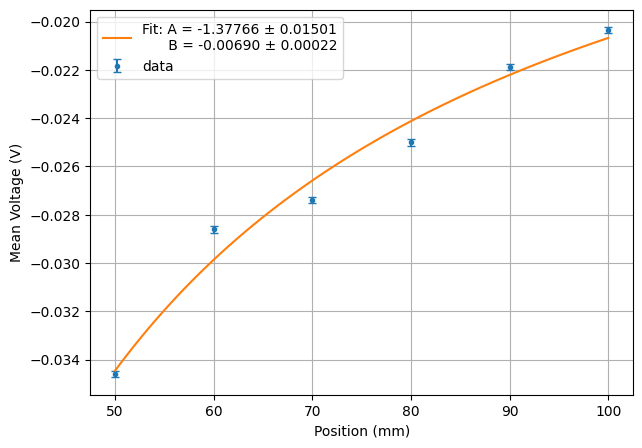

In [11]:
import numpy as np
from scipy.optimize import curve_fit

# --- N1 only ---
g = clean_df[clean_df['trial'] == 'N1'].sort_values('position')

r = g['position'].values
V = g['mean_voltage'].values
Verr = g['std_voltage'].values

# model
def inv_r_model(r, A, B):
    return A/r + B

# weighted fit
popt, pcov = curve_fit(inv_r_model, r, V, sigma=Verr, absolute_sigma=True)
A, B = popt
perr = np.sqrt(np.diag(pcov))

print(f"N1 fit: A = {A:.5f} ± {perr[0]:.5f}, B = {B:.5f} ± {perr[1]:.5f}")

# plot
r_fit = np.linspace(min(r), max(r), 100)
V_fit = inv_r_model(r_fit, *popt)

plt.figure(figsize=(7,5))
plt.errorbar(r, V, yerr=Verr, fmt='.', capsize=3, label='data')
plt.plot(r_fit, V_fit, '-', label=f"Fit: A = {A:.5f} ± {perr[0]:.5f}\n"
        f"      B = {B:.5f} ± {perr[1]:.5f}")
plt.xlabel("Position (mm)")
plt.ylabel("Mean Voltage (V)")
#plt.title("Fit to $Ar^{-1}$")
plt.grid(True)
plt.legend()
plt.savefig("inverseRfitFr.png", dpi=300, bbox_inches="tight")

plt.show()


N1 fit results: K = 1.36012, n = -0.997
Chi2 = 163.629, dof = 4, reduced Chi2 = 40.907
N1 power-law fit: K = 1.36012 ± 0.06233, n = -0.997 ± 0.011


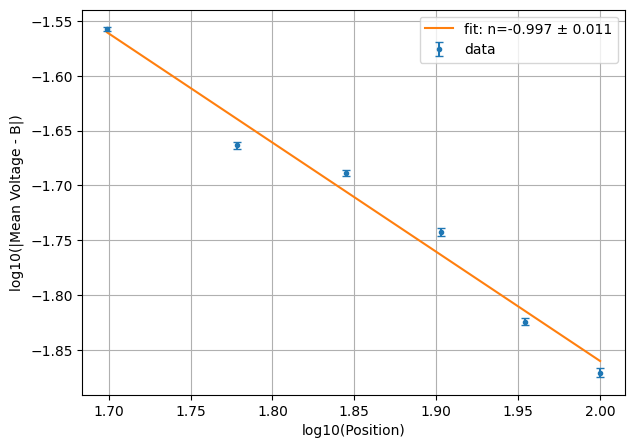

In [12]:
# function for log-log power-law fit
def power_law(r, K, n):
    return K * r**n

# --- only N1 ---
g = clean_df[clean_df['trial'] == 'N1'].sort_values('position')

r = g['position'].values
V = np.abs(g['mean_voltage'].values - B)
Verr = g['std_voltage'].values

# fit in linear space for correct weighting
popt, pcov = curve_fit(power_law, r, V, sigma=Verr, absolute_sigma=True)
K, n = popt
perr = np.sqrt(np.diag(pcov))

# chi-squared
V_model = power_law(r, *popt)
chi2 = np.sum(((V - V_model)/Verr)**2)
dof = len(V) - len(popt)
chi2_red = chi2 / dof

print(f"N1 fit results: K = {K:.5f}, n = {n:.3f}")
print(f"Chi2 = {chi2:.3f}, dof = {dof}, reduced Chi2 = {chi2_red:.3f}")
print(f"N1 power-law fit: K = {K:.5f} ± {perr[0]:.5f}, n = {n:.3f} ± {perr[1]:.3f}")

# plot log-log
r_fit = np.linspace(min(r), max(r), 100)
V_fit = power_law(r_fit, *popt)



plt.figure(figsize=(7,5))

plt.errorbar(np.log10(r), np.log10(V), yerr=Verr/V/np.log(10), fmt='.', capsize=3, label='data')
plt.plot(np.log10(r_fit), np.log10(V_fit), '-', label=f'fit: n={n:.3f} ± {perr[1]:.3f}')
plt.xlabel("log10(Position)")
plt.ylabel("log10(|Mean Voltage - B|)")
#plt.title("Log-Log Power Law Fit")
plt.grid(True)
plt.legend()
plt.savefig("powerFitFr.png", dpi=300, bbox_inches="tight")
plt.show()
